In [ ]:
### cloning repositories

!git clone https://github.com/anaguilarar/drone_data.git


In [3]:

import pickle
#import geopandas as gpd
import xarray
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import pandas as pd


from drone_data.utils.xr_functions import get_minmax_fromlistxarray
from drone_data.utils.data_processing import minmax_scale

# CNN yield prediction
## Images preprocessing

In this project, we are going to predict chinese cabagge yield, using a deep learning approach, several steps are needed before of training the models. 
First we need to scale the multiple layers, in this sense we use the maximum and minimum values of the whole dataset.
Then we applied a mimax scaler.
next steps is organize the yield field data, by rearrange the values in the same order of the drone imagery.

##### Config

In [7]:
FEATURES = [
    'red',
 'green',
 'blue',
 'grvi_rgb',
 'rgbvi_rgb',
 'ndvi',
 'ndre',
 'gndvi',
 'savi',
 'rgbvi',
 'z',
 'blue_ms',
 'green_ms',
 'red_ms',
 'edge',
 'nir']

INPUTPATH = "F:/OneDrive - The University of Tokyo/drone_data/results/xarraydata/tanashi/per_polygon/rgb_ms_xyz_rgbreference_26tp_centered/"
OUTPUTPATH = "F:/OneDrive - The University of Tokyo/drone_data/results/xarraydata/tanashi/per_polygon/rgb_ms_xyz_rgbreference_26tp_centered"

DATESTOSELECTFILE = "data/timpepoints_intervals.csv"

XDIMNAME = 'x'
yDIMNAME = 'y'


#### Selecting newsizes

 
This data set is created for convolutional neural network prediction. One requirement is that the inputs must have the same shape, for that reason, we reshape each array cube to a specific size.

In [76]:
from drone_data.utils.gis_functions import resize_4dxarray
from drone_data.utils.plt_functions import plot_multibands_fromxarray


In [11]:
### selecting sizes
xrfiles = os.listdir(INPUTPATH)
xrfiles = [i for i in xrfiles if i.endswith('pickle')]
allshapes = []
for xrfile in tqdm.tqdm(xrfiles):
    with open(os.path.join(INPUTPATH,"{}".format(
                xrfile)),"rb") as f:
        xrexample= pickle.load(f)

    allshapes.append([xrexample.dims[XDIMNAME],xrexample.dims[yDIMNAME]])

100%|██████████| 1154/1154 [05:01<00:00,  3.82it/s]


(array([  1.,   1.,  19.,  57., 206., 287., 374., 152.,  49.,   8.]),
 array([ 30.,  39.,  48.,  57.,  66.,  75.,  84.,  93., 102., 111., 120.]),
 <BarContainer object of 10 artists>)

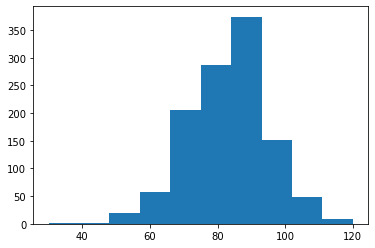

In [23]:
plt.hist(np.array(allshapes).T[0].astype(np.uint))

In [ ]:
### reseize a sample image

sizemethod = 'max'
if sizemethod == 'max':
    sizex, sizexy = np.max(allshapes, axis=0).astype(np.uint)
elif sizemethod == 'mean':
    sizex, sizexy = np.mean(allshapes, axis=0).astype(np.uint)
#elif sizemethod == 'median':
sizexm, sizexym = np.median(allshapes, axis=0).astype(np.uint)

print('the median shapes are in x:{} and in y:{}'.format(sizexm, sizexym))
print('the maximum shapes are in x:{} and in y:{}'.format(sizex, sizexy))
print('the final shape will {}'.format([84, 84]))

In [4]:
xrfiles = os.listdir(INPUTPATH)
xrfiles = [i for i in xrfiles if i.endswith('pickle')]

with open(os.path.join(INPUTPATH,"{}".format(
                xrfiles[0])),"rb") as f:
    xrexample= pickle.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'resized RGB image')

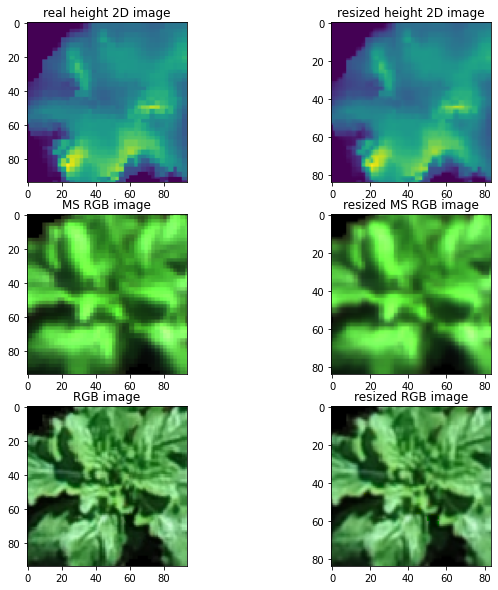

In [9]:

newsizex, newsizexy = [84, 84]

date = 2
xrresized = resize_4dxarray(xrexample, new_size=(newsizex, newsizexy), 
                            flip = False, blur = False)

fig, ax = plt.subplots(nrows = 3, ncols=2, figsize = (10,10))

ax[0,0].imshow(xrexample.isel(date = date).z.values)
ax[0,0].set_title('real height 2D image')
ax[0,1].imshow(xrresized.isel(date = date).z.values)
ax[0,1].set_title('resized height 2D image')

bandstoplot = ['red_ms','green_ms','blue_ms']
imgtoplot = xrexample[bandstoplot].isel(date = date).to_array().values
ax[1,0].imshow(imgtoplot.swapaxes(0,1).swapaxes(1,2)/0.2)
ax[1,0].set_title('MS RGB image')
imgtoplot = xrresized[bandstoplot].isel(date = date).to_array().values
ax[1,1].imshow(imgtoplot.swapaxes(0,1).swapaxes(1,2)/0.2)
ax[1,1].set_title('resized MS RGB image')

bandstoplot = ['red','green','blue']
imgtoplot = xrexample[bandstoplot].isel(date = date).to_array().values
ax[2,0].imshow(imgtoplot.swapaxes(0,1).swapaxes(1,2)/255)
ax[2,0].set_title('RGB image')
imgtoplot = xrresized[bandstoplot].isel(date = date).to_array().values
ax[2,1].imshow(imgtoplot.swapaxes(0,1).swapaxes(1,2)/255)
ax[2,1].set_title('resized RGB image')


##### Selecting time interval size

In [73]:

datawindows = pd.read_csv(DATESTOSELECTFILE)
datesoi = datawindows.loc[datawindows.windowsize == "7 days\r\n(14)"].dates.values
datawindows.loc[datawindows.windowsize == "7 days\r\n(14)"].head()

,Unnamed: 0,windowsize,windowf,selecteddays,centerp,dates,dateswindow,codcolumns
0,1,7 days\r\n(14),0,0,0.5,2021-09-22,2021-09-22,t0
1,2,7 days\r\n(14),7,7,0.5,2021-09-29,2021-09-29,t1
2,3,7 days\r\n(14),14,14,0.5,2021-10-06,2021-10-06,t3
3,4,7 days\r\n(14),21,22,0.5,2021-10-14,2021-10-13,t5
4,5,7 days\r\n(14),28,28,0.5,2021-10-20,2021-10-20,t7


In [74]:
### selecting date ids

datesoi_xrids = [j for j,i in enumerate(xrexample.date.values) 
                    if np.datetime_as_string(i, unit='D') in datesoi]
xrexample.isel(date = datesoi_xrids).date


<xarray.DataArray 'date' (date: 14)>
array(['2021-09-22T00:00:00.000000000', '2021-09-29T00:00:00.000000000',
       '2021-10-06T00:00:00.000000000', '2021-10-14T00:00:00.000000000',
       '2021-10-20T00:00:00.000000000', '2021-10-28T00:00:00.000000000',
       '2021-11-04T00:00:00.000000000', '2021-11-10T00:00:00.000000000',
       '2021-11-17T00:00:00.000000000', '2021-11-24T00:00:00.000000000',
       '2021-11-29T00:00:00.000000000', '2021-12-06T00:00:00.000000000',
       '2021-12-15T00:00:00.000000000', '2021-12-20T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2021-09-22 2021-09-29 ... 2021-12-20

#### exporting resized images

The imagery will be exported as a dictionary with attributes:
- variables: contains the values as an array with shape DxCxHxW
- dims: features/channels names
- attributes: geo spatial attributes

In [77]:
from drone_data.utils.xr_functions import CustomXarray
import tqdm

xrfiles = os.listdir(INPUTPATH)
xrfiles = [i for i in xrfiles if i.endswith('pickle')]

newsizex, newsizexy = [84, 84]
for i in tqdm.tqdm(range(len(xrfiles))):
    xrfile = xrfiles[i]
    
    with open(os.path.join(INPUTPATH,"{}".format(
                xrfile)),"rb") as f:
        xrexample= pickle.load(f)
        
    xrexampledois = xrexample.isel(date = datesoi_xrids).copy()
    
    xrresized = resize_4dxarray(xrexampledois, new_size=(newsizex, newsizexy), 
                            flip = False, blur = False)
    
    newxr = CustomXarray(xrresized)
    
    newxr.export_as_dict(path=OUTPUTPATH[:OUTPUTPATH.index('_26tp_centered')] + '_{}tp_size_{}'.format(
                                        len(datesoi_xrids), newsizex), 
                         fn = xrfile[:xrfile.index('.pickle')])


100%|██████████| 1154/1154 [16:59<00:00,  1.13it/s]


'id_plant_1144_rgbmspointcloud'

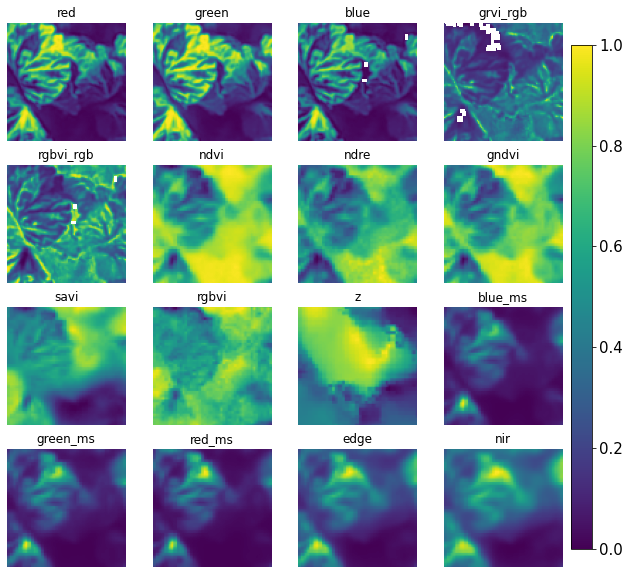

In [22]:
#### Reading an example

from Crop_SpatioMT.dataset import MT_Imagery
from drone_data.utils.plt_functions import plot_multichanels

arraymtdatapath = OUTPUTPATH[:OUTPUTPATH.index('_26tp_centered')] + '_{}tp_size_{}'.format(
                                        14, 84)

arfiles = os.listdir(arraymtdatapath)
arfiles = [i for i in arfiles if i.endswith('pickle')]

mtdata  = MT_Imagery(fromfile=os.path.join(arraymtdatapath,arfiles[0]), onlythesefeatures=FEATURES)

randtr = mtdata.to_npvalues()

t = 13
f,ax= plot_multichanels(np.array([minmax_scale(randtr[t][i]) for i in range(len(randtr[t]))]), 
                        num_rows=4, num_columns=4, chanels_names=mtdata.features)

In [25]:
for i, varname in enumerate(list(mtdata.features)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


### Getting image scalar values

In [5]:
from Crop_SpatioMT.dataset import get_minmax_from_mtfilespath

In [32]:
minvalues, maxvalues = get_minmax_from_mtfilespath(arraymtdatapath, featuresnames=FEATURES, depthpos=0)

100%|██████████| 1154/1154 [02:20<00:00,  8.21it/s]


In [38]:
with open('data/min_max_scalar.pickle','wb') as f:
    pickle.dump([minvalues, maxvalues],f)

In [43]:

mean_dict, std_dict = get_meanstd_mtfilespath(arraymtdatapath, featuresnames=FEATURES, depthpos=0)

100%|██████████| 1154/1154 [00:11<00:00, 99.09it/s] 


In [46]:
with open('data/standard_scalar.pickle','wb') as f:
    pickle.dump([mean_dict, std_dict],f)

### Splitting images into training, validation and testing

In [1]:
from drone_data.ml_utils.general_functions import SplitDatabyids
from Crop_SpatioMT.dataset import FolderWithImages
import pandas as pd
import numpy as np
import random



In [8]:
testidsplant = ['327', '586', '270', '178',  '903',  '1110', '976', '1015', '137', '347', '433', '1029', '1072', '96', '636', '984', '423',
 '51', '514', '889', '803', '1027', '20_last', '843', '4', '794', '986', '1063', '619', '990', '5_first', '970', '156', '3',
 '479', '931', '953', '299', '904', '1064', '337', '830', '168', '833', '42', '5', '60', '678', '589', '712', '1114', '321',
 '160', '644', '801', '368', '932', '557', '487', '913', '25', '605', '883', '513', '322', '305', '10', '621', '928', '188',
 '648', '123', '11', '385', '728', '549', '674', '1019', '183', '508', '807', '1115', '383']

testidsplant = ['3', '4', '5', '10', '11', '137', '51', '96', '60', '25',
       '5_first', '178', '183', '188', '156', '42', '270', '321', '160',
       '123', '168', '322', '368', '327', '337', '299', '487', '423',
       '383', '385', '347', '305', '619', '621', '586', '589', '549',
       '508', '514', '513', '433', '479', '794', '712', '674', '678',
       '636', '644', '557', '605', '803', '761', '809', '763', '727',
       '735', '699', '784', '788', '746', '745', '701', '790', '444',
       '370', '373', '259', '574', '492', '539', '458', '464', '339',
       '6_last', '7_last', '545', '720', '767', '695', '776', '4_first',
       '336', '9']

idplanttoremove = 664
arraymtdatapath = OUTPUTPATH[:OUTPUTPATH.index('_26tp_centered')] + '_{}tp_size_{}'.format(
                                        14, 84)

targetvar = 'total_w_x'
FILENAME = 'data/tanashi_cultivar_weigths_tp_phenomics_211220_vcenteredimgred_70_ph90_filt_.csv'
TRAININGPATH = 'mtdata'
df = pd.read_csv(FILENAME)

testindexes = [df.loc[df.id_plant == i].index[0] for i in df.id_plant.values if i in testidsplant]

notnaids = np.where(np.logical_not(np.isnan(df[targetvar])))
idswithweight =df.id_plant.iloc[notnaids].values

testindexes = [i for i in range(len(idswithweight)) if idswithweight[i] in testidsplant]

filesinfolder = os.listdir(arraymtdatapath)
filesinfolder = [i for i in filesinfolder if i.endswith('pickle')]


       
datasplitted = SplitDatabyids(idswithweight, test_ids=testindexes,kfolds=None,validation=True)


In [10]:
idswithweight[datasplitted.test_indexes]

array(['3', '4', '5', '10', '11', '137', '51', '96', '60', '25',
       '5_first', '178', '183', '188', '156', '42', '270', '321', '160',
       '123', '168', '322', '368', '327', '337', '299', '487', '423',
       '383', '385', '347', '305', '619', '621', '586', '589', '549',
       '508', '514', '513', '433', '479', '794', '712', '674', '678',
       '636', '644', '557', '605', '803', '761', '809', '763', '727',
       '735', '699', '784', '788', '746', '745', '701', '790', '444',
       '370', '373', '259', '574', '492', '539', '458', '464', '339',
       '6_last', '7_last', '545', '720', '767', '695', '776', '4_first',
       '336', '9'], dtype=object)

In [11]:

print('n training elements: {}'.format(len(datasplitted.cv_indexes[0][0])))
print('n validation elements: {}'.format(len(datasplitted.cv_indexes[0][1])))
print('n test elements: {}'.format(len(datasplitted.test_ids)))


n training elements: 681
n validation elements: 75
n test elements: 83


In [12]:
import shutil

if not os.path.exists(os.path.join(TRAININGPATH, 'tr')):
    os.mkdir(os.path.join(TRAININGPATH, 'tr'))
if not os.path.exists(os.path.join(TRAININGPATH, 'val')):
    os.mkdir(os.path.join(TRAININGPATH, 'val'))
if not os.path.exists(os.path.join(TRAININGPATH, 'test')):
    os.mkdir(os.path.join(TRAININGPATH, 'test'))
    
    
for i in datasplitted.cv_indexes[0][0]:
    if i != idplanttoremove:
        try:
            shutil.copy2(os.path.join(arraymtdatapath, 'id_plant_{}_rgbmspointcloud.pickle'.format(idswithweight[i])), 
                            os.path.join(TRAININGPATH, 'tr/'))
        except:
            pass

for i in datasplitted.cv_indexes[0][1]:
    if i != idplanttoremove:
        try:
            shutil.copy2(os.path.join(arraymtdatapath, 'id_plant_{}_rgbmspointcloud.pickle'.format(idswithweight[i])), 
                            os.path.join(TRAININGPATH, 'val/'))
        except:
            pass

for i in datasplitted.test_indexes:
    if i != idplanttoremove:
        try:
            shutil.copy2(os.path.join(arraymtdatapath, 'id_plant_{}_rgbmspointcloud.pickle'.format(idswithweight[i])), 
                            os.path.join(TRAININGPATH, 'test/'))
        except:
            pass
